# TensorFlow Hub 를 이용한 Transfer Learning

- Pre-trained Moblenet 사용

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet import decode_predictions

import numpy as np
import matplotlib.pyplot as plt
import time

## Flower Data download

In [2]:
flowers_data_path = tf.keras.utils.get_file(
  'flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True, cache_dir='/content/')
print(flowers_data_path)

228813984/228813984 [==============================] - 2s 0us/step
/content/datasets/flower_photos


- ImageDataGenerator 생성   
TensorFlow의 ImageDataGenerator 클래스를 사용하여 디렉토리에서 이미지를 로드하고, 이미지에 대한 전처리(여기서는 MobileNet의 전처리 함수를 사용)를 수행하고, 지정된 배치 크기로 이미지 데이터를 반환하는 데이터 제너레이터를 생성합니다.

In [4]:
# 모바일넷의 preprocess_input 함수를 사용해 이미지 데이터를 전처리
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

# flowers_data_path : 이미지 데이터가 있는 디렉토리의 경로입니다.
# target_size=(224, 224) : 모든 이미지의 크기를 (224, 224)로 조정
# batch_size = 64 : 한 번에 반환할 이미지의 수를 지정
# shuffle = True : 학습 데이터는 모델의 성능을 향상시키기 위해 섞어야 합니다.
flowers_data = image_generator.flow_from_directory(
                    flowers_data_path,
                    target_size=(224, 224),
                    batch_size = 64,
                    shuffle = True)

Found 3670 images belonging to 5 classes.


- flower data 는 5 개의 class 로 구성

In [5]:
input_batch, label_batch = next(flowers_data)

print("Image batch shape: ", input_batch.shape)
print("Label batch shape: ", label_batch.shape)
print("Label class 수: ", flowers_data.num_classes)
print("Class Index : ", flowers_data.class_indices)

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)
Label class 수:  5
Class Index :  {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


- 클래스의 이미지 수

In [23]:
class_counts = np.bincount(flowers_data.classes)
class_labels = flowers_data.class_indices

for label, count in zip(class_labels, class_counts):
    print(f"{label}: {count}")

daisy: 633
dandelion: 898
roses: 641
sunflowers: 699
tulips: 799


class name 표시를 위해 class_names dictionary 생성

In [6]:
class_names = {v:k for k,v in flowers_data.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

- 위에서 읽은 `input_batch` 중 10 개 image 시각화  
-  전처리된 image 를 reverse transform 하여 시각화

In [7]:
input_batch[0].min(), input_batch[0].max()

(-1.0, 1.0)

(-1.0, 1.0) 범위의 pixel 값을 (0, 255) 범위로 바꾸어 주기 위해 1 을 더해주고 127.5를 곱해준다.

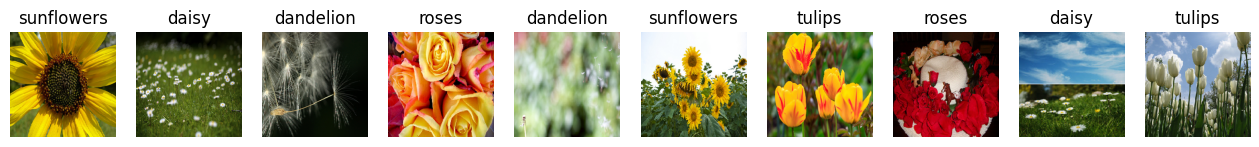

In [8]:
plt.figure(figsize=(16, 8))

for i in range(10):
    plt.subplot(1, 10, i+1)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    idx  = np.argmax(label_batch[i])
    plt.imshow(img)
    plt.title(class_names[idx])
    plt.axis('off')

## 전이학습 MODEL 을 특성 추출기로 사용하기 위해 head 가 제거된 model 을 download  

- [Tensorflow Hub](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2)

- `tf2-preview/mobilenet_v2/feature_vector/2`는 MobileNet V2의 feature vector를 가리킵니다. 이 feature vector는 MobileNet V2 모델의 마지막 분류 레이어를 제외한 부분을 나타내며, 이를 사용해 새로운 모델을 만들 때 전이 학습(Transfer Learning)을 쉽게 수행할 수 있습니다.

In [10]:
extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
extractor_layer = hub.KerasLayer(extractor_url, input_shape=(224, 224, 3))

In [11]:
feature_batch = extractor_layer(input_batch)
print(feature_batch.shape)

(64, 1280)


- MobileNet 의 pre-trained weight 는 update 않음  

- Top layer 에 Dense layer 추가

In [12]:
# extractor_layer의 가중치를 고정하고, 이후에 추가할 새로운 층의 가중치만을 학습하도록 설정
extractor_layer.trainable = False

두 조각으로 모델 만들기  
(1) MobileNet 특징 추출기  
(2) 마지막에 Dense Network(classifier) ​​추가

In [13]:
model = tf.keras.Sequential([
    extractor_layer,
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
model.input, model.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_input')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>)

- output shape 이 정확한지 training 전에 사전 check

In [15]:
predictions = model(input_batch)

predictions.shape

TensorShape([64, 5])

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
s = time.time()

history = model.fit(flowers_data, epochs=30)

Epoch 1/30
58/58 [==============================] - 19s 266ms/step - loss: 0.9390 - accuracy: 0.6499
Epoch 2/30
58/58 [==============================] - 16s 268ms/step - loss: 0.4844 - accuracy: 0.8354
Epoch 3/30
58/58 [==============================] - 16s 266ms/step - loss: 0.3893 - accuracy: 0.8695
Epoch 4/30
58/58 [==============================] - 16s 270ms/step - loss: 0.3420 - accuracy: 0.8869
Epoch 5/30
58/58 [==============================] - 16s 270ms/step - loss: 0.3067 - accuracy: 0.8967
Epoch 6/30
58/58 [==============================] - 15s 266ms/step - loss: 0.2819 - accuracy: 0.9071
Epoch 7/30
58/58 [==============================] - 15s 263ms/step - loss: 0.2570 - accuracy: 0.9183
Epoch 8/30
58/58 [==============================] - 15s 266ms/step - loss: 0.2373 - accuracy: 0.9229
Epoch 9/30
58/58 [==============================] - 16s 267ms/step - loss: 0.2168 - accuracy: 0.9316
Epoch 10/30
58/58 [==============================] - 15s 265ms/step - loss: 0.2074 - accura

In [18]:
print("경과 시간 (분) :", (time.time() - s)/60)

경과 시간 (분) : 7.792576384544373


## Flower 분류 전문으로 Fine Tuning 된 MODEL 평가

In [19]:
y_pred = model.predict(input_batch)
y_pred = np.argmax(y_pred, axis=-1)
y_pred

2/2 [==============================] - 1s 14ms/step


array([3, 0, 1, 2, 1, 3, 4, 2, 0, 4, 0, 0, 4, 4, 0, 0, 4, 4, 2, 2, 0, 2,
       0, 0, 1, 3, 0, 1, 1, 3, 4, 0, 4, 2, 2, 2, 4, 2, 1, 0, 1, 0, 1, 1,
       0, 2, 1, 3, 0, 2, 4, 2, 4, 2, 4, 4, 3, 2, 4, 0, 0, 3, 1, 3])

In [20]:
y_true = np.argmax(label_batch, axis=-1)
y_true

array([3, 0, 1, 2, 1, 3, 4, 2, 0, 4, 0, 0, 4, 4, 0, 0, 4, 4, 2, 2, 0, 2,
       0, 0, 1, 3, 0, 1, 1, 3, 4, 0, 4, 2, 2, 2, 4, 2, 1, 0, 1, 0, 1, 1,
       0, 2, 1, 3, 0, 2, 4, 2, 4, 2, 4, 4, 3, 2, 4, 0, 0, 3, 1, 3])

In [21]:
f"{sum(y_pred == y_true) / len(y_true) * 100:.2f} %"

'100.00 %'

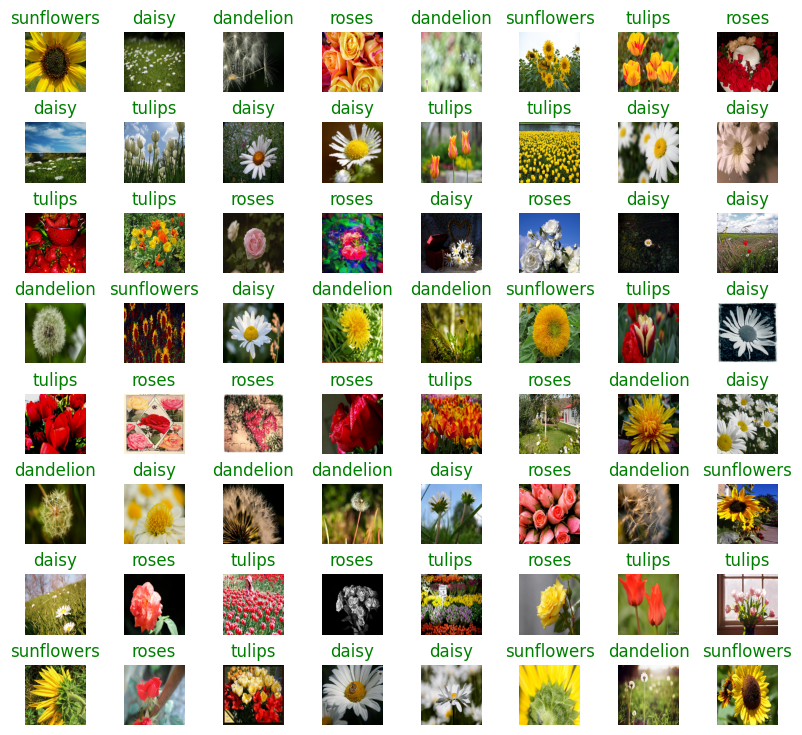

In [22]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for i in range(64):
  plt.subplot(8, 8, i+1)
  img = ((input_batch[i]+1)*127.5).astype(np.uint8)
  plt.imshow(img)
  color = "green" if y_pred[i] == y_true[i] else "red"
  plt.title(class_names[y_pred[i]], color=color)
  plt.axis('off')
